## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)

2.154434690031884


In [4]:
parameter_names_1  = set(list(np.array(parameter_names).ravel()))
for p in parameter_names_1:
    print(p)

alpha
amplitude
beta


In [5]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 5.32 s, sys: 284 ms, total: 5.6 s
Wall time: 5.6 s


## Datasets

In [6]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if sys == "Eff_area":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)


## Minos

In [7]:
numpoints = 20

In [8]:
def computing_scan(dataset, note):
        
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(dataset)
    print(dataset_asimov.models[0])
    
    results = []
    for parname1 in parameter_names_1 :
        print( parname1)
        dataset.models.parameters[parname1].scan_n_values=numpoints
        result = fit_cor.stat_profile(dataset,
                             dataset.models.parameters[parname1],
                            reoptimize = False
                            )

        contour_write = dict()
        for k in result.keys():
            print(k)
            if k != "success":
                contour_write[k] = [float(_) for _ in result[k]]#.tolist()
        print(contour_write)
        with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}.yml", "w") as outfile:
            yaml.dump(contour_write, outfile, default_flow_style=False)

        results.append(result)
    return results
        
def read_in_scan(note):
    results = []
    for parname1 in parameter_names_1 :
        with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}.yml", "r") as stream:
            contour = yaml.safe_load(stream)
        results.append(contour)
    return results

In [9]:
%%time
computing = 0
if computing:
    results = computing_scan(dataset_asimov, "2.15h")
else:
    results = read_in_scan("2.15h")
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
    


CPU times: user 24.2 ms, sys: 67 µs, total: 24.3 ms
Wall time: 23.7 ms


In [10]:
%%time
computing = 0

if computing:
    results_N = computing_scan(dataset_asimov_N, "N_2.15h")
else:
    results_N = read_in_scan("N_2.15h")
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        


CPU times: user 90.6 ms, sys: 20.9 ms, total: 112 ms
Wall time: 111 ms


alpha
amplitude
beta


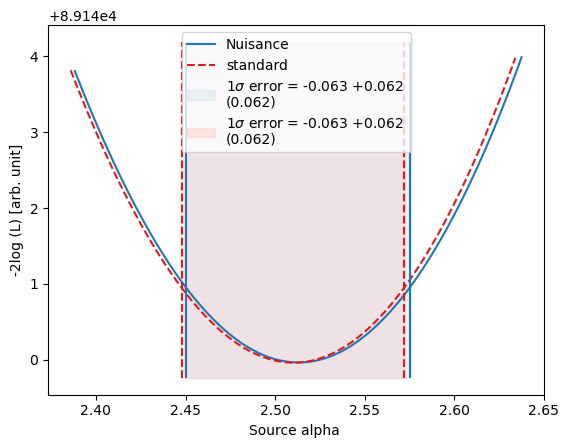

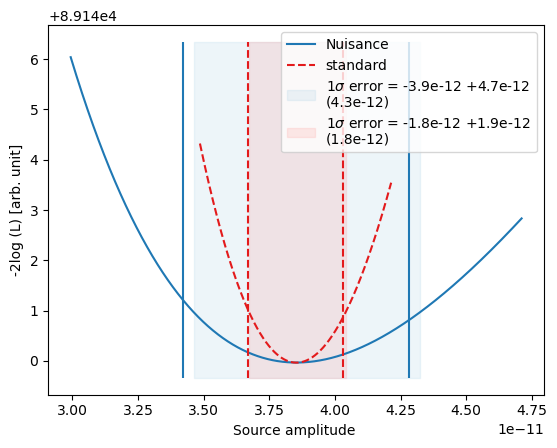

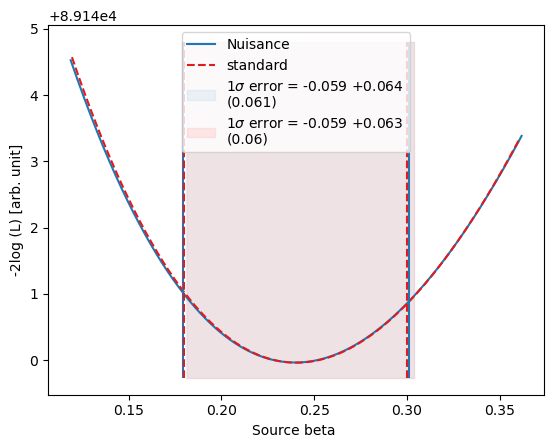

In [11]:
import upper_limit_18_02
for i, p in enumerate(parameter_names_1):
    print(p)
    stat_profile_N = results_N[i]
    stat_profile = results[i]

    fig = plt.figure()
    ll_N_a = stat_profile_N.copy()
    ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0, 
                                           name=f'{dataset_asimov.models[0].name}.spectral.{p}_scan')
    L_N_a, x_N_a = ul_N_a.interpolate()
    plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance", color = aw[0])


    ll_a = stat_profile.copy()
    ul_a = upper_limit_18_02.upper_limit(ll_a,0,0,  name=f'{dataset_asimov.models[0].name}.spectral.{p}_scan')
    L_a, x_a = ul_a.interpolate()
    plt.plot(x_a, L_a(x_a),label = "standard", linestyle = 'dashed', color = awo[0])

    amplitude_err = dataset_asimov.models[0].parameters[p].error
    amplitude = dataset_asimov.models[0].parameters[p].value
    amplitude_err_N = dataset_asimov_N.models[0].parameters[p].error
    amplitude_N = dataset_asimov_N.models[0].parameters[p].value



    min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    dataset_asimov_N.models.parameters[p].error_n = er_neg
    dataset_asimov_N.models.parameters[p].error_p = er_pos
    
    
    ax = plt.gca()
    ylim= ax.get_ylim()
    ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.2, color = aw[1],
                    label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err_N:.2})')
    ax.vlines(amplitude_N-amplitude_err_N, ylim[0], ylim[1],color = aw[0] )
    ax.vlines(amplitude_N+amplitude_err_N, ylim[0], ylim[1],color = aw[0] )
    
    ax.vlines(amplitude-amplitude_err, ylim[0], ylim[1], color = awo[0], linestyle ='dashed')
    ax.vlines(amplitude+amplitude_err, ylim[0], ylim[1], color = awo[0], linestyle ='dashed')
    
    min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    dataset_asimov.models.parameters[p].error_n = er_neg
    dataset_asimov.models.parameters[p].error_p = er_pos
    
    ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.2, color=awo[1],
                    label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err:.2})')

    plt.xlabel(f"Source {p} ")
    plt.ylabel("-2log (L) [arb. unit]")
    plt.legend()

    fig.savefig(f"../{c['folder']}/plots/4_scan_{p}.pdf")

In [12]:
path = f'../{folder}/data/0_model_nui_livetime_{livetime}_np.yml'
dataset_asimov_N.models.write(path, overwrite = 1)

path = f'../{folder}/data/0_model_livetime_{livetime}_np.yml'
dataset_asimov.models.write(path, overwrite = 1)